In [2]:
pip install yfinance ta

In [3]:
import pandas as pd
import numpy as np
from ta.trend import SMAIndicator
from ta.volatility import BollingerBands

# YFinance
import yfinance as yf

# Matplotlib
import matplotlib.pyplot as plt
import matplotlib.style
plt.style.use('ggplot')

In [9]:
# Data usando YFinance
data = yf.download('AUDUSD=X', interval = '1d', start = '2015-01-01', end = '2022-03-24')
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-01,0.817127,0.817127,0.816993,0.817127,0.817127,0
2015-01-02,0.818197,0.818465,0.810373,0.817795,0.817795,0
2015-01-05,0.807363,0.810767,0.803859,0.806777,0.806777,0
2015-01-06,0.809520,0.815927,0.808865,0.809979,0.809979,0
2015-01-07,0.807885,0.808277,0.803729,0.808016,0.808016,0
...,...,...,...,...,...,...
2022-03-18,0.738160,0.741098,0.736279,0.738100,0.738100,0
2022-03-21,0.741021,0.742512,0.737490,0.740999,0.740999,0
2022-03-22,0.739459,0.745000,0.737580,0.739579,0.739579,0


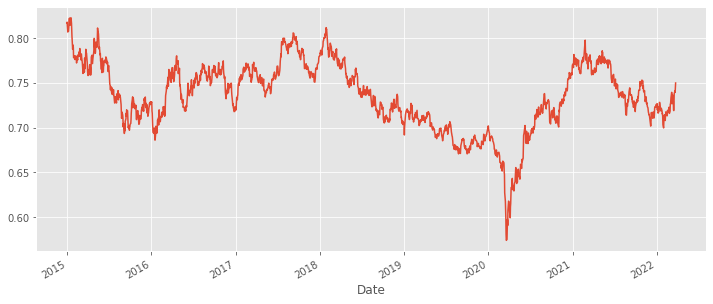

In [10]:
data['Close'].plot(figsize=(12, 5))
plt.show()

In [12]:
# Calculo de las Bandas de Bollinger (con biblioteca TA)
BB = BollingerBands(data['Close'], 14, 2, False)

# Bandas Bollinger
data['BB-B. Alta'] = BB.bollinger_hband()
data['BB-B. Baja'] = BB.bollinger_lband()
data['BB-B. Media'] = BB.bollinger_mavg()

data

,Open,High,Low,Close,Adj Close,Volume,BB-B. Alta,BB-B. Baja,BB-B. Media
Date,,,,,,,,,
2015-01-01,0.817127,0.817127,0.816993,0.817127,0.817127,0,NaN,NaN,NaN
2015-01-02,0.818197,0.818465,0.810373,0.817795,0.817795,0,NaN,NaN,NaN
2015-01-05,0.807363,0.810767,0.803859,0.806777,0.806777,0,NaN,NaN,NaN
2015-01-06,0.809520,0.815927,0.808865,0.809979,0.809979,0,NaN,NaN,NaN
2015-01-07,0.807885,0.808277,0.803729,0.808016,0.808016,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2022-03-18,0.738160,0.741098,0.736279,0.738100,0.738100,0,0.741674,0.718097,0.729885
2022-03-21,0.741021,0.742512,0.737490,0.740999,0.740999,0,0.743823,0.718062,0.730943
2022-03-22,0.739459,0.745000,0.737580,0.739579,0.739579,0,0.745205,0.718600,0.731902


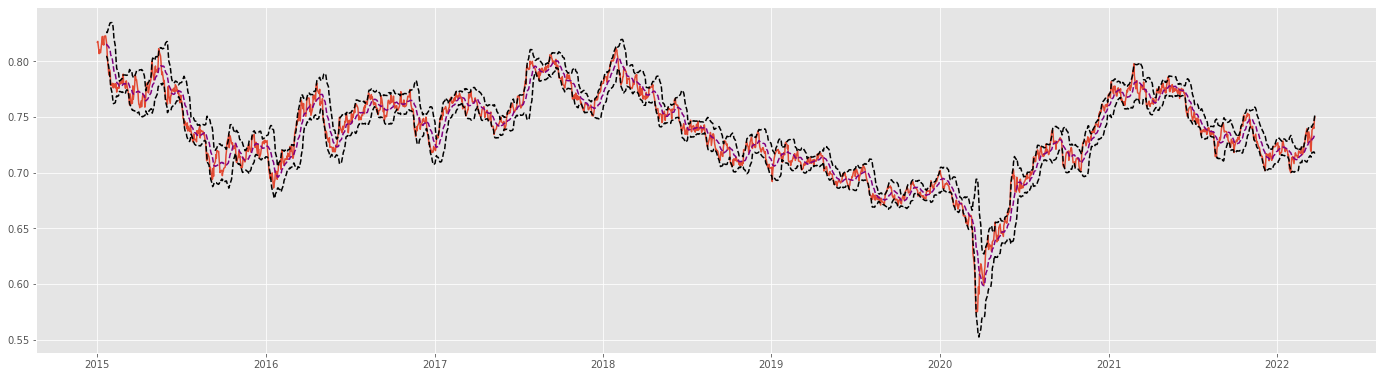

In [13]:
fig = plt.figure(figsize=(24, 14))

ax1 = plt.subplot2grid((2, 1), (1, 0), rowspan = 2, colspan = 1)
ax1.plot(data['Close'])

ax1.plot(data['BB-B. Alta'], color = 'black', ls = '--')
ax1.plot(data['BB-B. Baja'], color = 'black', ls = '--')
ax1.plot(data['BB-B. Media'], color = 'purple', ls = '--')

Para nuestra estrategia, agregaremos un ***filtro***, siendo dos SMAs de 50 y 100

In [14]:
# Desde el indicador principal, usamos el método deseado para extraer los valores reales
# y colocarlos en una nueva columna
data['SMA-50'] = SMAIndicator(data['Close'], 50, False).sma_indicator()
data['SMA-100'] = SMAIndicator(data['Close'], 100, False).sma_indicator()

In [17]:
# Partimos el dataframe para una mejor visualizacion en el plot
data_s = data.loc['2019' : '2022']

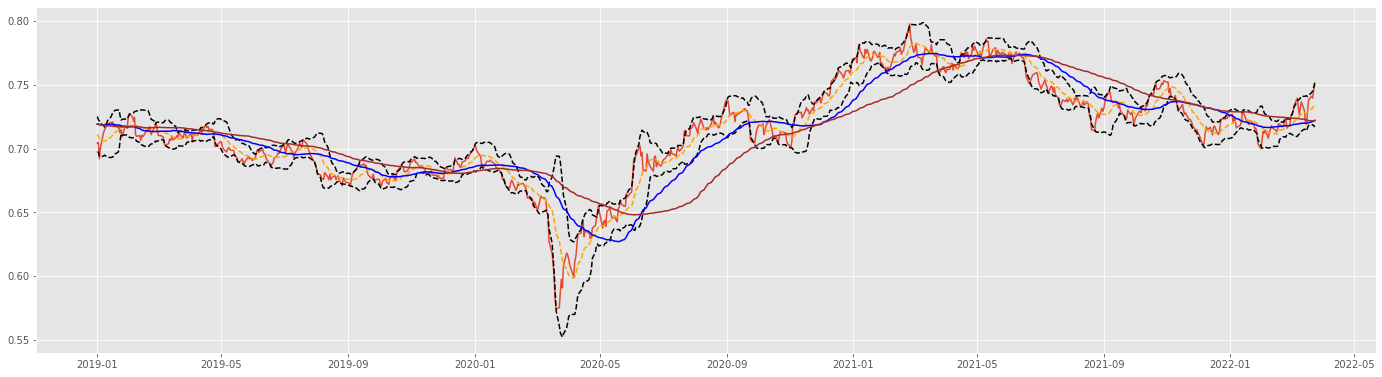

In [18]:
fig = plt.figure(figsize=(24, 14))

ax1 = plt.subplot2grid((2, 1), (1, 0), rowspan = 2, colspan = 1)
ax1.plot(data_s['Close'])

ax1.plot(data_s['BB-B. Alta'], color = 'black', ls = '--')
ax1.plot(data_s['BB-B. Baja'], color = 'black', ls = '--')
ax1.plot(data_s['BB-B. Media'], color = 'orange', ls = '--')

ax1.plot(data_s['SMA-50'], color = 'blue')
ax1.plot(data_s['SMA-100'], color = 'brown')

---
Ahora vamos a implementar la estrategia usando nuestras clases

## La Clase **TesterBase** *(parent)*

Nuestra clase **TesterBase** queda exactamente igual, no hemos agregado ningun cambio

In [19]:
class TesterBase():
  def __init__(self, simbolo, data_origen, inicio, final, monto, usar_spread=True):
    self.simbolo = simbolo
    self.data_origen = data_origen # Implementamos el metodo 'data_origen'
    self.inicio = inicio
    self.final = final
    self.balance_inicial = monto
    self.balance_actual = monto
    self.unidades_en_activos = 0 
    self.trades = 0      
    self.posicion = 0
    self.usar_spread = usar_spread
    self.obtener_data()

  def obtener_data(self):
    if self.data_origen == "local":
      ruta_data = "...ruta al archivo .csv..."
      # raw = pd.read_csv(ruta_data, parse_dates=['Gmt time'], index_col="Gmt time").dropna() # Formatea data DUKASCOPY
      # raw = raw.loc[self.inicio : self.final]
      # self.data = raw

    if self.data_origen == "yahoo":
      raw = yf.download(self.simbolo, interval="1d", start=self.inicio, end=self.final)
      raw = raw.rename(columns = {'Close':'Precio'})

      # Comprueba si el dataframe tiene la columna 'Spread'. De lo contrario, 
      # crea una columna llamada "Spread" con valores 0
      if 'Spread' in raw.columns or 'spread' in raw.columns:
        self.data = raw
      else:
        raw['Spread'] = 0
        self.data = raw

  def obtener_valores_por_index(self, vela):
    date = str(self.data.index[vela].date())
    precio = round(self.data['Precio'].iloc[vela], 5)
    spread = round(self.data['Spread'].iloc[vela], 5)
    return date, precio, spread

  def imprimir_balance_actual(self, vela):
    date, precio, spread = self.obtener_valores_por_index(vela)
    print("{} | Balance Inicial: {}".format(self.inicio, round(self.balance_inicial, 2)))
    print("{} | Balance Actual: {}".format(date, round(self.balance_actual, 2)))

  def comprar_instrumento(self, vela, unidades_en_activos=None, monto=None):
    date, precio, spread = self.obtener_valores_por_index(vela)
    if self.usar_spread:
      precio += spread/2 # Precio ASK
    if monto is not None: 
      unidades_en_activos = int(monto / precio) 
    self.balance_actual -= unidades_en_activos * precio 
    self.unidades_en_activos += unidades_en_activos
    self.trades += 1
    print("{} | Comprando: {}, {}, por: {}".format(date, unidades_en_activos, self.simbolo, precio))

  def vender_instrumento(self, vela, unidades_en_activos=None, monto=None):
    date, precio, spread = self.obtener_valores_por_index(vela)
    if self.usar_spread:
      precio -= spread/2 # Precio BID 
    if monto is not None: 
      unidades_en_activos = int(monto / precio) 
    self.balance_actual += unidades_en_activos * precio 
    self.unidades_en_activos -= unidades_en_activos
    self.trades += 1
    print("{} | Vendiendo: {}, {}, por: {}".format(date, unidades_en_activos, self.simbolo, precio))

  def imprimir_valor_de_posicion_actual(self, vela):
    date, precio, spread = self.obtener_valores_por_index(vela)
    cpv = self.unidades_en_activos * precio
    print("{} | Valor de la posicion actual: {}".format(date, cpv))

  def imprimir_valor_neto_del_activo(self, vela):
    date, precio, spread = self.obtener_valores_por_index(vela)
    net_asset_value = self.balance_actual + (self.unidades_en_activos * precio)
    print("{} | Valor Neto Actual: {}".format(date, net_asset_value))

  def cerrar_posicion(self, vela):
    date, precio, spread = self.obtener_valores_por_index(vela)
    print(100 * "-")
    print("{} | \-\-\-\-\-\ FINAL DEL BACKTEST /-/-/-/-/-/". format(date))
    self.balance_actual += self.unidades_en_activos * precio 
    self.balance_actual -= (abs(self.unidades_en_activos) * (spread / 2) * self.usar_spread)
    print("{} | Cerrando posicion de: {} | por: {}".format(date, self.unidades_en_activos, precio))
    self.unidades_en_activos = 0 
    self.trades += 1
    perf = (self.balance_actual - self.balance_inicial) / self.balance_inicial * 100 
    self.imprimir_balance_actual(vela)
    print("{} | Rendimiento Neto (%): {}".format(date, round(perf, 2)))
    print("{} | Numero de Trades: {}".format(date, self.trades))
    print(100 * "-") 

  # Performance de la Estrategia
  def Medidores_de_Riesgo(self):
    df = self.data.copy().dropna()
    riskfree_rate = 0.022

    # Prepara los datos que son necesarios para el uso del metodo 'Medidores_de_Riesgo'
    df['instrumento_retornos']   = df['Precio'].pct_change()
    df['estrategia_retornos'] = df['Posicion'].shift(1) * df['instrumento_retornos']
    # df.dropna(inplace=True)
    df['instrumento_retornos_acum'] = df['instrumento_retornos'].cumsum().apply(np.exp)
    df['estrategia_retornos_acum'] = df['estrategia_retornos'].cumsum().apply(np.exp)

    # Performance Absoluto ----------------------------------------------------/
    perf = df['estrategia_retornos_acum'].iloc[-1] 
    # % Superado --------------------------------------------------------------/
    pct_superado = perf - df['instrumento_retornos_acum'].iloc[-1] 
    # CAGR --------------------------------------------------------------------/
    numero_de_anios = len(df)/252 
    CAGR = (df['estrategia_retornos_acum'][-1])**(1/numero_de_anios) -1 
    # Volatilidad Anual -------------------------------------------------------/
    vol = df['instrumento_retornos'].std()* np.sqrt(252) 
    # Sharpe Ratio ------------------------------------------------------------/
    sharpe_ratio = (CAGR - riskfree_rate) / vol
    # Sortino Ratio -----------------------------------------------------------/
    neg_vol = df[df['instrumento_retornos'] < 0]['instrumento_retornos'].std()* np.sqrt(252) 
    sortino_ratio = (CAGR - riskfree_rate) / neg_vol
    # MDD ---------------------------------------------------------------------/
    df['max_ret_acum'] = df['estrategia_retornos_acum'].cummax()
    df['drawdown']     = df['max_ret_acum'] - df['estrategia_retornos_acum']
    df['drawdown_pct'] = df['drawdown'] / df['max_ret_acum']
    mdd                = df['drawdown_pct'].max()
    # Calmar Ratio ------------------------------------------------------------/
    calmar = CAGR / mdd
    # Imprime los valores con su respectivo texto -----------------------------/
    print("RENDIMIENTO DE LA ESTRATEGIA")
    print("-" * 100)
    print("% Superado al Benchmark:__" + str(round((pct_superado*100), 2)) + "%")
    print("CAGR (Rendimiento Anual)__" + str(round((CAGR*100), 2)) + "%")
    print("Volatilidad Anual:________" + str(round((vol*100), 2)) + "%")
    print("Maximum Drawdown:_________" + str(round((mdd*100), 2)) + "%")
    print("Sharpe R._________________" + str(round(sharpe_ratio, 2)))
    print("Sortino R.________________" + str(round(sortino_ratio, 2)))
    print("Calmar R._________________" + str(round(calmar, 2)))
    print("-" * 100)

  def plotear_data(self, cols=None):
    if cols is None:
      cols = 'Precio'
    self.data[cols].plot(figsize=(12,6), title=self.simbolo)

In [20]:
class BacktesterIterativo(TesterBase):
  
  # Metodo ayuda Comprar
  def ir_long(self, vela, unidades_en_activos=None, monto=None):
    if self.posicion == -1: 
      self.comprar_instrumento(vela, unidades_en_activos= -self.unidades_en_activos) 
    if unidades_en_activos:
      self.comprar_instrumento(vela, unidades_en_activos= unidades_en_activos)
    elif monto:
      if monto == 'todo':
        monto = self.balance_actual
      self.comprar_instrumento(vela, monto=monto) # Ir Long

  # Metodo ayuda Vender
  def ir_short(self, vela, unidades_en_activos=None, monto=None):
    if self.posicion == 1: 
      self.vender_instrumento(vela, unidades_en_activos= self.unidades_en_activos)
    if unidades_en_activos:
      self.vender_instrumento(vela, unidades_en_activos = unidades_en_activos)
    elif monto:
      if monto == 'todo':
        monto = self.balance_actual
      self.vender_instrumento(vela, monto=monto) # Ir Short

  # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
  # ESTRATEGIA CRUCE SMA -------------------------------------------------------------------------------------+
  # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
  def Estrategia_Cruce_SMAs(self, sma_rapida, sma_lenta, plot_graph=True):

    # Imprime datos de la estrategia
    stm = "TESTANDO LA ESTRATEGIA: Cruce de SMAs | {} | sma_rapida: {} | sma_lenta: {}".format(self.simbolo, sma_rapida, sma_lenta)
    print("-" * 100)
    print(stm)
    print("-" * 100)

    # Resetea el backtest
    self.posicion = 0 # Posicion inicial neutral
    self.trades   = 0 # No Trades aun
    self.balance_actual = self.balance_inicial # Resetea el capital inicial
    self.obtener_data() # Resetea la data

    # Preparar datos (calcula las SMAs)
    from ta.trend import SMAIndicator

    # Al principio nombramos la nueva columna según el valor que se coloca en los parámetros SMAs
    self.data["SMA_R: "+str(sma_rapida)] = SMAIndicator(self.data['Precio'], sma_rapida, False).sma_indicator() 
    self.data["SMA_L: "+str(sma_lenta)]  = SMAIndicator(self.data['Precio'], sma_lenta, False).sma_indicator() 
    self.data.dropna(inplace=True)

    # Cruce de las SMAs 
    self.data['Posicion'] = 0 # Crea la columna 'Posición' (la usaremos para plotear los resultados)

    for vela in range(len(self.data)-1): # Todas las velas excepto la última vela

      # Senal para ir Long
      if self.data["SMA_R: "+str(sma_rapida)].iloc[vela] > self.data["SMA_L: "+str(sma_lenta)].iloc[vela]: 
        if self.posicion in [0, -1]: # Comprueba si la posición es neutra (0) o Short (-1)
          self.ir_long(vela, monto = 'todo') # Ir Long con todo el monto disponible
          self.posicion = 1 # Posicion Long 
          
          # Popula la columna 'posiciones' en cada loop (con señales de compra (1))          
          self.data.at[self.data.index[vela], 'Posicion'] = self.posicion 
      
      # Senal para ir Short
      elif self.data["SMA_R: "+str(sma_rapida)].iloc[vela] < self.data["SMA_L: "+str(sma_lenta)].iloc[vela]: 
        if self.posicion in [0, 1]: # Comprueba si la posición es neutra (0) o Long (1)
          self.ir_short(vela, monto = 'todo') # Ir Short con todo el monto disponible
          self.posicion = -1 # Posicion Short 
          
          # Popula la columna 'posiciones' en cada loop (con señales de venta (-1))
          self.data.at[self.data.index[vela], 'Posicion'] = self.posicion 

    if self.trades > 0:
      self.cerrar_posicion(vela+1) # Cierra la posicion en la ultima vela
    else:
      print("NO HAY TRADES EN ESTE PERIODO DE TIEMPO. Prueba con otro período")
      print(100 * "-")

    # Imprime los Medidores de Riesgo en la estrategia
    self.Medidores_de_Riesgo()

    # Plotea el grafico de la estrategia, incluido los marcadores de los trades
    if plot_graph and self.trades > 0:
      fig = plt.figure(figsize=(24,18))
      ax1 = plt.subplot2grid((2,1), (1,0), rowspan=2, colspan=1)
      ax1.plot(self.data['Precio'], label="precio", color='black')
      ax1.plot(self.data["SMA_R: "+str(sma_rapida)], label = str(sma_rapida) + " periodos SMA")
      ax1.plot(self.data["SMA_L: "+str(sma_lenta)], label = str(sma_lenta) + " periodos SMA")
      # Plotea Trades en Long
      ax1.plot(self.data[self.data['Posicion'] == 1].index, 
              self.data['Precio'][self.data['Posicion'] == 1], '^', markersize = 15, color='green', label='Long')
      # Plotea Trades en Short
      ax1.plot(self.data[self.data['Posicion'] == -1].index, 
              self.data['Precio'][self.data['Posicion'] == -1], 'v', markersize = 15, color='red', label='Short')

      plt.title(self.simbolo +"\n Estrategia Cruce SMAs "+str(sma_rapida)+ " - " +str(sma_lenta), fontsize = 20)
      plt.legend(fontsize = 15)
      plt.show()

  # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
  # ESTRATEGIA CRUCE RSI -------------------------------------------------------------------------------------+
  # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
  def Estrategia_Cruce_RSI(self, sobrecomprado=70, sobrevendido=30, plot_graph=True):
    
    # Imprime datos de la estrategia
    stm = "TESTANDO LA ESTRATEGIA: Cruce de RSI | {} | sobrecomprado: {} | sobrevendido: {}".format(self.simbolo, sobrecomprado, sobrevendido)
    print("-" * 100)
    print(stm)
    print("-" * 100)

    # Resetea el backtest
    self.posicion = 0 # Posicion inicial neutral
    self.trades   = 0 # No Trades aun
    self.balance_actual = self.balance_inicial # Resetea el capital inicial
    self.obtener_data() # Resetea la data
    
    # Preparar datos (calcula el RSI)
    from ta.momentum import rsi 
    self.data['RSI'] = rsi(self.data['Precio'], 14, False)

    # Cruce RSI 
    self.data['Posicion'] = 0 # Crea la columna 'Posición' (la usaremos para plotear los resultados)

    for vela in range(len(self.data)-1): # Todas las velas excepto la última

      # Senal para ir Long
      if self.data["RSI"].iloc[vela] < sobrevendido: 
        if self.posicion in [0, -1]: # Comprueba si la posición es neutra (0) o Short (-1)
          self.ir_long(vela, monto = 'todo') # Ir Long con todo el monto disponible
          self.posicion = 1 # Posicion Long
          
          # Popula la columna 'posiciones' en cada loop (con señales de compra (1))          
          self.data.at[self.data.index[vela], 'Posicion'] = self.posicion 

      # Senal para ir Short
      elif self.data["RSI"].iloc[vela] > sobrecomprado:
        if self.posicion in [0, 1]: # Comprueba si la posición es neutra (0) o Long (1)
          self.ir_short(vela, monto = 'todo') # Ir Short con todo el monto disponible
          self.posicion = -1 # Posicion Short 

          # Popula la columna 'posiciones' en cada loop (con señales de venta (-1))
          self.data.at[self.data.index[vela], 'Posicion'] = self.posicion 

    if self.trades > 0:
      self.cerrar_posicion(vela+1) # Cierra la posicion en la ultima vela
    else:
      print("NO HAY TRADES EN ESTE PERIODO DE TIEMPO. Prueba con otro período")
      print(100 * "-")

    # Imprime los Medidores de Riesgo en la estrategia
    self.Medidores_de_Riesgo()

    # Plotea el grafico de la estrategia, incluido los marcadores de los trades
    if plot_graph and self.trades > 0:
      fig = plt.figure(figsize=(24,18))

      ax1 = plt.subplot2grid((9,1), (1,0), rowspan=4, colspan=1)
      ax1.plot(self.data['Precio'], color='black')      
      # Plotea Trades Long, en el Grafico del Precio
      ax1.plot(self.data[self.data['Posicion'] == 1].index, 
              self.data['Precio'][self.data['Posicion'] == 1], '^', markersize = 15, color='green', label='Long')
      # Plotea Trades Short, en el Grafico del Precio
      ax1.plot(self.data[self.data['Posicion'] == -1].index, 
              self.data['Precio'][self.data['Posicion'] == -1], 'v', markersize = 15, color='red', label='Short')
      
      ax2 = plt.subplot2grid((9,1), (5,0), rowspan=2, colspan=1, sharex=ax1)
      ax2.plot(self.data['RSI'], color='orange')
      # Plotea Senales Long, en el Grafico RSI
      ax2.plot(self.data[self.data['Posicion'] == 1].index, 
              self.data['RSI'][self.data['Posicion'] == 1], '^', markersize = 15, color='green', label='Long')
      # Plotea Senales Short, en el Grafico RSI
      ax2.plot(self.data[self.data['Posicion'] == -1].index, 
              self.data['RSI'][self.data['Posicion'] == -1], 'v', markersize = 15, color='red', label='Short')
      # Plotea lineas de referencia en el Grafico RSI
      ax2.axhline(70, color='red', linestyle='dotted', linewidth=2)
      ax2.axhline(30, color='green', linestyle='dotted', linewidth=2)
      ax2.set_yticks([30,70])
      ax2.set_title("RSI", loc='left')

      fig.suptitle(self.simbolo +"\n Estrategia Cruce RSI", fontsize = 20)
      plt.subplots_adjust(top=1.05, hspace=0)
      plt.show()
  
  # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
  # ESTRATEGIA BOLLINGER BANDS con filtro SMAs ---------------------------------------------------------------+
  # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
  def Estrategia_BB(self, BB_periodos=20, BB_std=2, sma_rapida=50, sma_lenta=200, plot_graph=True):
    
    # Imprime datos de la estrategia
    stm = "TESTANDO LA ESTRATEGIA: Bollinger Bands | Periodos: {} | Std: {}".format(self.simbolo, BB_periodos, BB_std)
    print("-" * 100)
    print(stm)
    print("-" * 100)

    # Resetea el backtest
    self.posicion = 0 # Posicion inicial neutral
    self.trades   = 0 # No Trades aun
    self.balance_actual = self.balance_inicial # Resetea el capital inicial
    self.obtener_data() # Resetea la data

    # Preparar datos (calcula las BBs y SMAs)
    from ta.volatility import BollingerBands
    from ta.trend import SMAIndicator

    BB = BollingerBands(self.data['Precio'], BB_periodos, BB_std, False)    
    self.data['BB-B. Alta']              = BB.bollinger_hband()
    self.data['BB-B. Baja']              = BB.bollinger_lband()
    self.data['BB-B. Media']             = BB.bollinger_mavg()
    self.data["SMA_R: "+str(sma_rapida)] = SMAIndicator(self.data['Precio'], sma_rapida, False).sma_indicator() 
    self.data["SMA_L: "+str(sma_lenta)]  = SMAIndicator(self.data['Precio'], sma_lenta, False).sma_indicator() 
    self.data.dropna(inplace=True)
        
    # Logica de la estrategia (Bandas Bollinger + filtro SMA)
    self.data['Posicion'] = 0 # Crea la columna 'Posición' (la usaremos para plotear los resultados)

    for vela in range(len(self.data)-1): # Todas las velas excepto la última vela
    
      # Filtro SMAs
      if self.data["SMA_R: "+str(sma_rapida)].iloc[vela] > self.data["SMA_L: "+str(sma_lenta)].iloc[vela]:
        if self.data['Precio'].iloc[vela] < self.data["SMA_L: "+str(sma_lenta)].iloc[vela]:
          # Senal BB
          if self.data['Precio'].iloc[vela] <= self.data['BB-B. Media'].iloc[vela]:
            if self.posicion in [0, -1]: # Comprueba si la posición es neutra (0) o Short (-1)
              self.ir_long(vela, monto = 'todo') # Ir Long con todo el monto disponible
              self.posicion = 1 # Posicion Long

              # Popula la columna 'posiciones' en cada loop (con señales de compra (1)) 
              self.data.at[self.data.index[vela], 'Posicion'] = self.posicion 
      
      # Filtro SMAs
      elif self.data["SMA_R: "+str(sma_rapida)].iloc[vela] < self.data["SMA_L: "+str(sma_lenta)].iloc[vela]: 
        if self.data['Precio'].iloc[vela] > self.data["SMA_L: "+str(sma_lenta)].iloc[vela]:
          # Senal BB
          if self.data['Precio'].iloc[vela] >= self.data['BB-B. Media'].iloc[vela]: 
            if self.posicion in [0, 1]: # Comprueba si la posición es neutra (0) o Long (1)
              self.ir_short(vela, monto = 'todo') # Ir Short con todo el monto disponible
              self.posicion = -1 # Posicion Short 

              # Popula la columna 'posiciones' en cada loop (con señales de venta (-1))
              self.data.at[self.data.index[vela], 'Posicion'] = self.posicion 
    
    if self.trades > 0:
      self.cerrar_posicion(vela+1) # Cierra la posicion en la ultima vela
    else:
      print("NO HAY TRADES EN ESTE PERIODO DE TIEMPO. Prueba con otro período")
      print(100 * "-")

    # Imprime los Medidores de Riesgo en la estrategia
    self.Medidores_de_Riesgo()

    # Plotea el grafico de la estrategia, incluido los marcadores de los trades
    if plot_graph and self.trades > 0:
      fig = plt.figure(figsize=(24,18))
      ax1 = plt.subplot2grid((2,1), (1,0), rowspan=2, colspan=1)
      ax1.plot(self.data['Precio'], label="Precio", color='black')
      ax1.plot(self.data['BB-B. Alta'], color='black', ls='--')
      ax1.plot(self.data['BB-B. Baja'], color='black', ls='--')
      ax1.plot(self.data['BB-B. Media'], color='grey', ls='--')
      ax1.plot(self.data["SMA_R: "+str(sma_rapida)], label = str(sma_rapida) + " dias SMA")
      ax1.plot(self.data["SMA_L: "+str(sma_lenta)], label = str(sma_lenta) + " dias SMA")
      # Plotea Trades en Long
      ax1.plot(self.data[self.data['Posicion'] == 1].index, 
              self.data['Precio'][self.data['Posicion'] == 1], '^', markersize = 15, color='green', label='Long')
      # Plotea Trades en Short
      ax1.plot(self.data[self.data['Posicion'] == -1].index, 
              self.data['Precio'][self.data['Posicion'] == -1], 'v', markersize = 15, color='red', label='Short')

      plt.title(self.simbolo +"\n Estrategia Bollinger Bands", fontsize = 20)
      plt.legend(fontsize = 15)
      plt.show()

In [21]:
# Obteniendo la data de origen "local"
# bkbase = BacktesterIterativo("EURUSD", "local", "2006-12-31", "2020-06-30", 100000, usar_spread=False)

# Obteniendo la data de origen "yahoo" - FOREX
bkbase = BacktesterIterativo("AUDUSD=X", "yahoo", "2015-12-31", "2020-06-30", 100000, usar_spread=False)

# Obteniendo la data de origen "yahoo" - STOCKS
# bkbase = BacktesterIterativo("TSLA", "yahoo", "2015-01-01", "2020-01-01", 100000, usar_spread=False)

[*********************100%***********************]  1 of 1 completed


In [22]:
bkbase.data

,Open,High,Low,Precio,Adj Close,Volume,Spread
Date,,,,,,,
2015-12-31,0.728385,0.732547,0.728120,0.728491,0.728491,0,0
2016-01-01,0.727167,0.727167,0.727167,0.727167,0.727167,0,0
2016-01-04,0.728597,0.729288,0.716846,0.728704,0.728704,0,0
2016-01-05,0.718339,0.721657,0.713419,0.718597,0.718597,0,0
2016-01-06,0.716178,0.717309,0.705816,0.716281,0.716281,0,0
...,...,...,...,...,...,...,...
2020-06-24,0.694440,0.696400,0.686600,0.694030,0.694030,0,0
2020-06-25,0.685860,0.689000,0.684820,0.685678,0.685678,0,0
2020-06-26,0.688840,0.689800,0.684230,0.688819,0.688819,0,0


----------------------------------------------------------------------------------------------------
TESTANDO LA ESTRATEGIA: Bollinger Bands | Periodos: AUDUSD=X | Std: 20
----------------------------------------------------------------------------------------------------
[*********************100%***********************]  1 of 1 completed
2016-06-09 | Vendiendo: 133390, AUDUSD=X, por: 0.74968
2016-06-28 | Comprando: 133390, AUDUSD=X, por: 0.73573
2016-06-28 | Comprando: 138448, AUDUSD=X, por: 0.73573
2016-08-11 | Vendiendo: 138448, AUDUSD=X, por: 0.77155
2016-08-11 | Vendiendo: 138448, AUDUSD=X, por: 0.77155
2016-12-01 | Comprando: 138448, AUDUSD=X, por: 0.73888
2016-12-01 | Comprando: 150691, AUDUSD=X, por: 0.73888
2017-03-16 | Vendiendo: 150691, AUDUSD=X, por: 0.77059
2017-03-16 | Vendiendo: 150691, AUDUSD=X, por: 0.77059
2017-05-18 | Comprando: 150691, AUDUSD=X, por: 0.74311
2017-05-18 | Comprando: 161836, AUDUSD=X, por: 0.74311
2017-07-21 | Vendiendo: 161836, AUDUSD=X, por: 0.7947

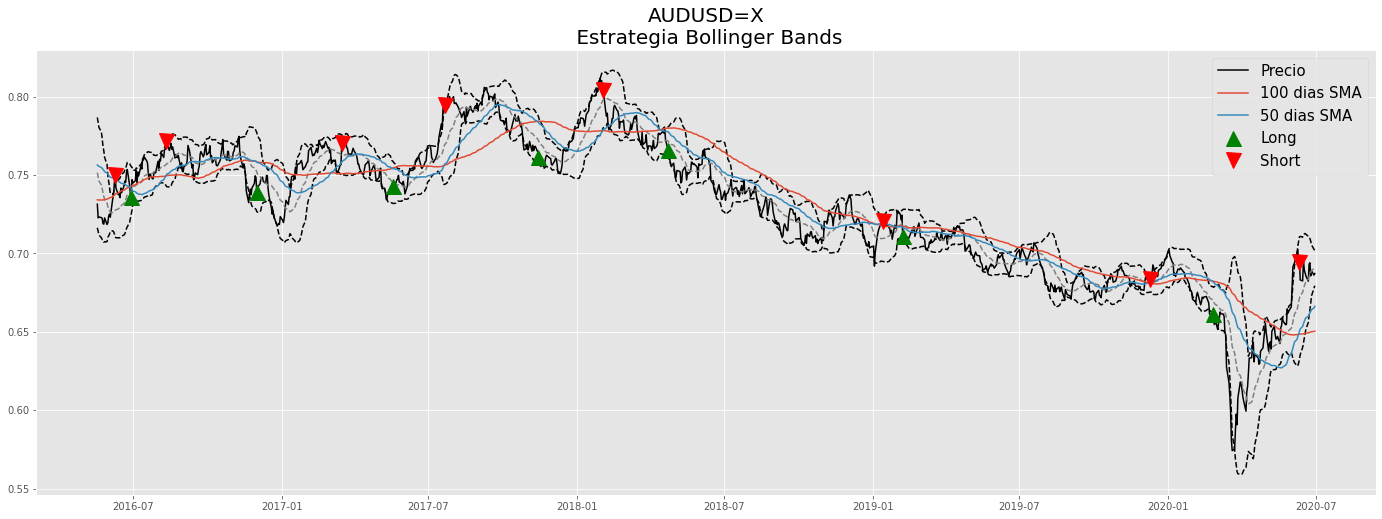

In [23]:
bkbase.Estrategia_BB(sma_lenta = 50, sma_rapida = 100)

Testando en solamente una seccion de la data

In [24]:
bkbase = BacktesterIterativo("EURUSD=X", "yahoo", "2019-01-01", "2021-01-01", 100000, usar_spread=False)

[*********************100%***********************]  1 of 1 completed


In [25]:
bkbase.data

,Open,High,Low,Precio,Adj Close,Volume,Spread
Date,,,,,,,
2019-01-01,1.149425,1.155001,1.146500,1.149306,1.149306,0,0
2019-01-02,1.146132,1.149700,1.134572,1.146171,1.146171,0,0
2019-01-03,1.131734,1.140914,1.131734,1.131811,1.131811,0,0
2019-01-04,1.139095,1.141774,1.134816,1.139108,1.139108,0,0
2019-01-07,1.141292,1.147447,1.140524,1.141044,1.141044,0,0
...,...,...,...,...,...,...,...
2020-12-28,1.220703,1.225200,1.218353,1.220510,1.220510,0,0
2020-12-29,1.222001,1.227599,1.222001,1.222345,1.222345,0,0
2020-12-30,1.225325,1.230875,1.225205,1.225295,1.225295,0,0


----------------------------------------------------------------------------------------------------
TESTANDO LA ESTRATEGIA: Bollinger Bands | Periodos: EURUSD=X | Std: 20
----------------------------------------------------------------------------------------------------
[*********************100%***********************]  1 of 1 completed
2019-05-20 | Comprando: 89563, EURUSD=X, por: 1.11653
2019-08-06 | Vendiendo: 89563, EURUSD=X, por: 1.12438
2019-08-06 | Vendiendo: 89563, EURUSD=X, por: 1.12438
2019-08-19 | Comprando: 89563, EURUSD=X, por: 1.10939
2019-08-19 | Comprando: 91983, EURUSD=X, por: 1.10939
2019-12-06 | Vendiendo: 91983, EURUSD=X, por: 1.11054
2019-12-06 | Vendiendo: 91983, EURUSD=X, por: 1.11054
2020-02-18 | Comprando: 91983, EURUSD=X, por: 1.08401
2020-02-18 | Comprando: 96485, EURUSD=X, por: 1.08401
2020-06-15 | Vendiendo: 96485, EURUSD=X, por: 1.1252
2020-06-15 | Vendiendo: 96485, EURUSD=X, por: 1.1252
------------------------------------------------------------------

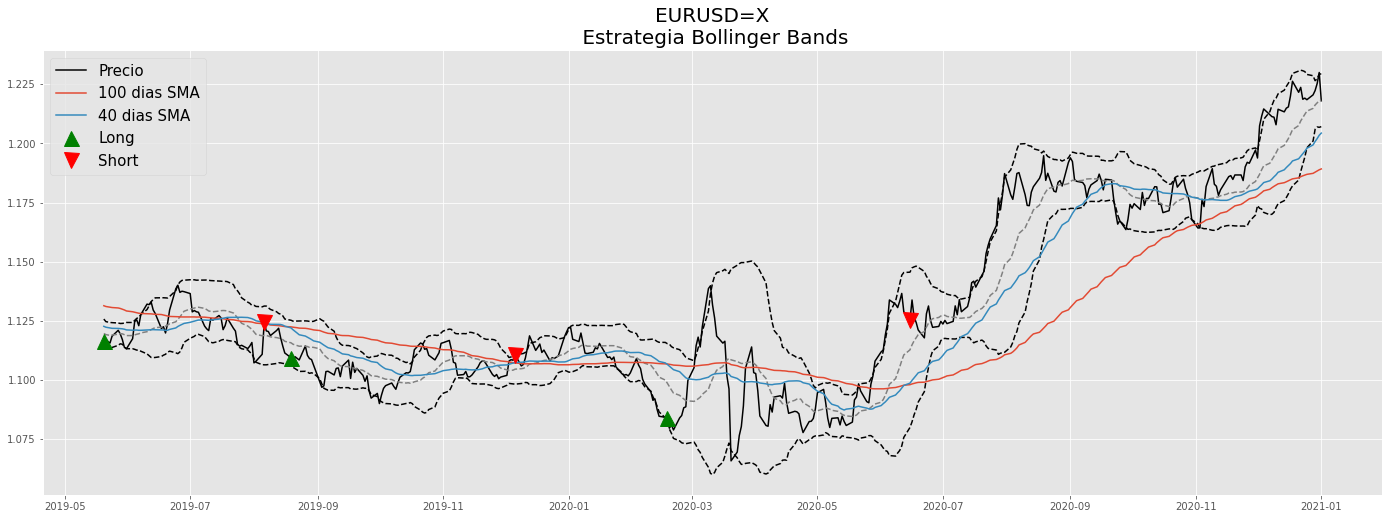

In [26]:
bkbase.Estrategia_BB(sma_lenta = 40, sma_rapida = 100)